### 逻辑斯蒂回归
1. 第一部分介绍了线性回归，但是对于线性不可分的情况，线性回归就无法满足需求，此时逻辑斯蒂回归（logisitc regression）就出现了，它是一个分类模型，是利用统计学中的一种模型，且可用于多种条件分类。
2. 最后推导出的形式与线性回归的梯度下降法极其相似，因此可以将第一部分的`__partial_update_wight`和`net_input`函数重新实现就可轻松写出逻辑斯蒂回归代码。
3. 详细介绍：
首先引入一个概念，几率比$P=\frac{p}{1-p}$，他是指一个事件发生概率与未发生概率的比值，容易的$P>0$ ，其中$p$是正事件（记为$y=1$）发生的概率。 
于是我们取其对数有：
$$
log(P(y=1|x))=log(\frac{p(y=1|x)}{1-p(y=1|x)}) 
$$
而$log(P(y=1|x)) \in (-\infty,+\infty)$，故我们可有：
$$
log(\frac{p(y=1|x)}{1-p(y=1|x)})  = w^Tx
$$
$$
p(y=1|x) = \frac{1}{1+e^{-w^Tx}}
$$
我们将上式简写为：
$$
p(y=1|x) = \frac{1}{1+e^{-w^Tx}} = \phi(z(x))
$$
那现在就相当于是要求在$p(y=1|x)$最大的情况下，权重$w$的值。所以我们可以构建最大似然函数：
$$
\begin{align}  
L(w) &= P(y|x;w) \\
&= \prod_{i=1}^{n}P(y^{(i)}|x^{(i)};w) \\
&= \prod_{i=1}^{n}\phi(z(x^{(i)}))^{y^{(i)}}(1-\phi(z(x^{(i)})))^{1-y^{(i)}}
\end{align}  
$$
按照传统的最大似然函数解法，我们首先两边取对数
$$
\begin{align}  
log(L(w)) &= log(\prod_{i=1}^{n}\phi(z(x^{(i)}))^{y^{(i)}}\phi(z(x^{(i)}))^{1-y^{(i)}}) \\
&= \sum_{i=1}^{n}y^{(i)}log(\phi(z(x^{(i)})))+(1-y^{(i)})log(1-\phi(z(x^{(i)})))
\end{align}  
$$
故逻辑斯蒂回归的代价函数为
$$
J(w)= \sum_{i=1}^{n}y^{(i)}log(\phi(z(x^{(i)})))+(1-y^{(i)})log(1-\phi(z(x^{(i)})))
$$
按照1-2节的思路，对$w$求偏导有：
$$
\begin{align}
\frac{\partial J(w)}{\partial w_j} = \sum_{i=1}^n(\phi(z^{(i)})-y^{(i)})x_j
\end{align}
$$
这样，给出样本$x$和权重$w$，我们就可得到该样本属于特定类别的概率。
$$
w := w + \eta \sum_{i}(y^{(i)}-\phi (z^{(i)})x^{(i)}_j 
$$
可以看到，这和第一部分的规则是一样的，但是要注意$\phi(x)$函数不同。
4. 本次以吴恩达的机器学习课程中的数据为基础进行训练，这份数据是一些学生两门课的成绩以及他们是否顺利考入了大学被录取（0代表否）。

In [5]:
import numpy as np
from numpy import random
from scipy.special import expit

class LogisticReg:
    
    def __init__(self, learn_rate, iter_nums):
        """
            构造函数，初始化梯度下降参数
            parameters:
            learn_rate: float, 学习速率
            iter_nums： int,   迭代次数
            
            return: LogisticReg object
        
        """
        self.learn_rate = learn_rate
        self.iter_nums = iter_nums
        self.wight = None
        self.costs = []
    
    def fit(self, X, Y):
        """
            parameters:
            X: np.ndarray, size:[simples,features]
            Y：np.ndarray, size:features
            
            return: self
        """
        simples,features = X.shape
        self.__init_wight(features+1)
        
        # 经过测试，对于numpy的一维向量，numpy会自动进行广播（brodacast）扩展维度，不需要考虑维度
        # Y = Y.reshape((simples, 1))
        
        for _ in range(self.iter_nums):
            cost = 0
            for x,y in zip(X,Y):
                cost += self.__partial_update_wight(x,y)
            # average cost
            self.costs.append(cost / len(Y))
        
        return self
    
    def __init_wight(self, rows, cols = 1): 
        self.wight = np.random.random(rows)
        # self.wight = np.zeros(rows)
    
    
    
    def __partial_update_wight(self, X, Y):
        """
        单个样本权重更新
        parameters:
            X: np.ndarray, 特征值，a vector that its length is count of features.
            Y：np.ndarray, 实际值，a vector that its length is count of features.
            
            return: cost
        """
        output = self.net_input(X)
        _error = Y - output
        self.wight[1:] += self.learn_rate * np.dot(X, _error)
        self.wight[0]  += self.learn_rate * _error
        # cost
        return -Y*np.log(output)-(1-Y)*np.log(1-output)
        
        
    def net_input(self, x):
        """
            parameters:
            x: np.ndarray, size:[simples,features]

            return: np.ndarray, size:[simples,1]
        """
        
        return expit(self.wight[0] + np.dot(x, self.wight[1:,]))
    
    def predict(self, x):
        """
            parameters:
            x: n.ndarray, size:[simples,features]
            
            return: np.ndarray, size:[simples,1]
        """
        return np.where(self.net_input(x) >= 0.5, 1, 0)

### 线性化逻辑斯蒂回归
#### 数据读取、处理
对数据进行特征缩放，即数据标准化，对第$j$个特征的一系列值进行标准化处理，公式为：
$$
x_j^{'}=\frac{x_j-u_j}{\sigma_j}
$$

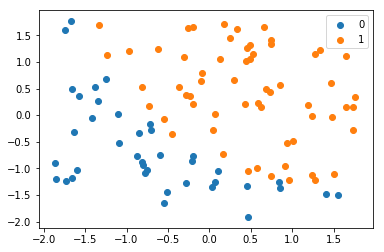

In [6]:
import pandas as pd
df = pd.read_csv('ex2data1.txt', delimiter=",", header=0)

Y = df.iloc[0:100,2].values
X = df.iloc[0:100,[0,1]].values

# 对数据进行标准化
X[:, 0] = (X[:, 0] - X[:, 0].mean()) / X[:,0].std()
X[:, 1] = (X[:, 1] - X[:, 1].mean()) / X[:,1].std()

# 绘图
from matplotlib import pyplot as plt
%matplotlib inline
ax = plt.axes()

ax.scatter(X[Y==0,0],X[Y==0,1],label='0')
ax.scatter(X[Y==1,0],X[Y==1,1],label='1')
ax.legend()

可以看到这份数据集是线性不可分的

### 批量梯度训练模型

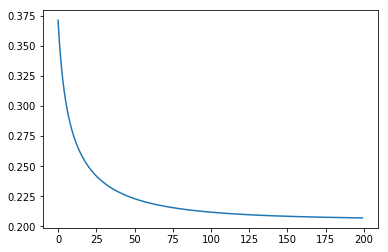

In [11]:
learn_rate = 0.01
iter_nums = 200
gd = LogisticReg(learn_rate, iter_nums)
gd.fit(X, Y)

# 绘制损耗函数
ax = plt.axes()
ax.plot(gd.costs)

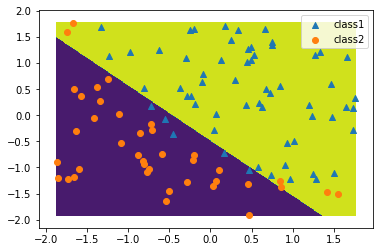

In [12]:
# 构建源数据
interval = 0.01
x0_min, x0_max = X[:, 0].min(),X[:, 0].max()
x1_min, x1_max = X[:, 1].min(),X[:, 1].max()

xy, yx = np.meshgrid(np.arange(x0_min, x0_max, interval),
                    np.arange(x1_min, x1_max,interval))

z = np.array([xy.ravel(), yx.ravel()]).T

# 预测
z_predict = []
for _z in z:
    z_predict.append(gd.predict(_z))
    
z_predict = np.array(z_predict).reshape(xy.shape)
# 绘制结果
ax = plt.axes()
ax.contourf(xy, yx, z_predict)
# 绘制原始数据
ax.scatter(X[Y == 1,0], X[Y == 1,1], marker='^', label='class1')
ax.scatter(X[Y == 0,0], X[Y == 0,1], marker='o', label='class2')
ax.legend()

1. 可以看到对于线性问题，逻辑斯蒂回归也是有着不错的分类效果。
2. 在训练时，我将数据进行了标准化，我发现如果不进行标准化，分类效果很差，所以逻辑斯蒂回归是否一定要标准化？